## Plot the emittance growth rate vs different values of noise.
- The simulation code is ran 3 times to imporve the accuracy, with different seeds of random numbers where they appear (eg ζ at the white noise kick and the initial particle distributions. 
- The emittance growth is averaged ovr turns and the variance is estimated. 

### test that you have acces to the /afs directory where your data are stored
If permision denied
- $USERNAME@CERN.CH 
- aklog

In [1]:
ls /afs/cern.ch/work/n/natriant/private

my_tracking_model_htcondor/  simulation_data_2018/  sixdesk/  workspaces/


In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from math import *

### Plotting parameters

In [3]:
params = {'legend.fontsize': 20,
          'figure.figsize': (8.5, 7),
          'axes.labelsize': 27,
          'axes.titlesize': 23,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

### Compute emittance

In [4]:
# #--- <x^2> ---
def mean2(numb):
    return np.mean( (numb - np.mean(numb))**2 )

# #--- <xx'> ---
def mean3(numbx , numbpx):
    return np.mean( (numbx - np.mean(numbx)) * (numbpx - np.mean(numbpx)) )

# #--- sqrt(<x^2> * <px^2> - <xx'>^2) --- compute statistical emittance
def cmp_emit(position, angle):
    return  np.sqrt(mean2(position) * mean2(angle) - mean3(position,angle)**2) # geometrical emittance

### Import the parameters of the study

In [6]:
data = {}
with open('./configuration_files/config_rate_vs_gain.json', "r") as read_file:
        data = json.load(read_file)
my_afs_path = '/afs/cern.ch/work/n/natriant/private/my_tracking_model_htcondor/tracking_data/'

### Loop over delta values and the three versions

In [8]:
gain_list = np.geomspace(data['Feedback']['values_limits']['min'], data['Feedback']['values_limits']['max'], data['Feedback']['values_limits']['step']) #the real deltas values, as the ones in the names are shorted
versions = [1, 2, 3]
print(gain_list)

[0.01       0.01459233 0.0212936  0.03107233 0.04534176 0.06616418
 0.09654894 0.14088738 0.20558748 0.3       ]


### Loop over studies. Dictionaries to store the emittance values over turns, 1 dictionay for each version, 1 for each value of delta

In [9]:
ex_dictionary = {}
for version in versions:
    ex_dictionary['v{}'.format(version)] = {}
    for gain in gain_list:
        ex_dictionary['v{}'.format(version)]['gain{}'.format(gain)] = []
        df = pd.read_pickle(my_afs_path+'Qx62.78_ksi0.010_g{:.3f}_delta0.050_betax115.75_particles15000_turns1000_v{}.pkl'.format(gain, version))
        for turn in range(data['study_parameters']['turns']):
            ex_dictionary['v{}'.format(version)]['gain{}'.format(gain)].append(cmp_emit(df.at[turn, 'x']/sqrt(data['machine_parameters']['beta_x']), df.at[turn, 'px']*sqrt(data['machine_parameters']['beta_x'] )))

### Plot emittance evolution over turns

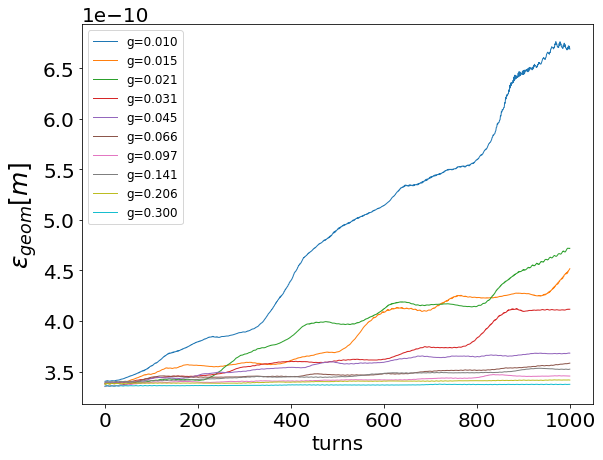

In [33]:
#Delta_test = Deltas_list[3]
version_test = 1
turns_list = np.arange(0, data['study_parameters']['turns'])
for gain_test in gain_list:
    plt.plot(turns_list, ex_dictionary['v{}'.format(version_test)]['gain{}'.format(gain_test)], label = 'g={:.3f}'.format(gain_test))
savefig = False
plt.xlabel('turns')
plt.ylabel(r'$\epsilon_{geom}  [m]$', fontsize = 25)
plt.legend()
plt.tight_layout()
if savefig: 
    plt.savefig('./figures/emittance_evolution_Qx62.78_ksi0.010_gScan_delta0.050_betax115.75_particles15000_turns1000.png')#.format(Delta_test))

### Plot rate vs noise strength vs version
- The color code indicate different versions
- Do a linear fit on the emittance values for each value of Delta, to obtain the emittance growth rate.
- The rate for each vale and run/version is also saved for future use

Text(0, 0.5, '$\\frac{1}{\\epsilon_0} \\frac{d\\epsilon}{dn}$')

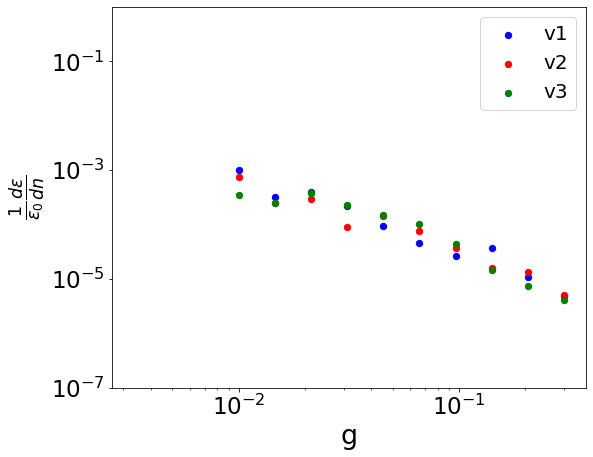

In [10]:
fig, ax = plt.subplots()
turns_list = np.arange(0, data['study_parameters']['turns'])

colors = ['b', 'r', 'g']
color_pointer = 0

rate_dictionary = {} # this dicitonary stores the emittance growth rate for every noise (Delta) value for each one of the different runs (versions)
for version in versions:
    rate_dictionary['v{}'.format(version)] = {}
    for gain in gain_list:
        rate_dictionary['v{}'.format(version)]['gain{}'.format(gain)] = []


for version in versions:
    for index, gain in enumerate(gain_list):
        current_study =  ex_dictionary['v{}'.format(version)]['gain{}'.format(gain)][0:]
        # Do the linear fit
        [m_h,b_h], cov_h = np.polyfit(turns_list[0:], current_study/current_study[0], 1, cov= True)
        err_h = np.sqrt(np.diag(cov_h))
        rate_dictionary['v{}'.format(version)]['gain{}'.format(gain)].append(m_h)
        if index == 0:
            ax.scatter(gain, m_h, s=40, c = colors[color_pointer], label = 'v{}'.format(version))
        else:
            ax.scatter(gain, m_h, s=40, c = colors[color_pointer])
    color_pointer = color_pointer+1
plt.legend()
ax.set_ylim(10e-8, 10e-1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('g')
ax.set_ylabel(r'$\frac{1}{\epsilon_0} \frac{d\epsilon}{dn}$', fontsize = 25)

### Plot averaged rate vs noise
- The emittance growth is averaged over runs, aka versions and the variance is estimated

Text(0, 0.5, '$\\frac{1}{\\epsilon_0} \\frac{d\\epsilon}{dn}$')

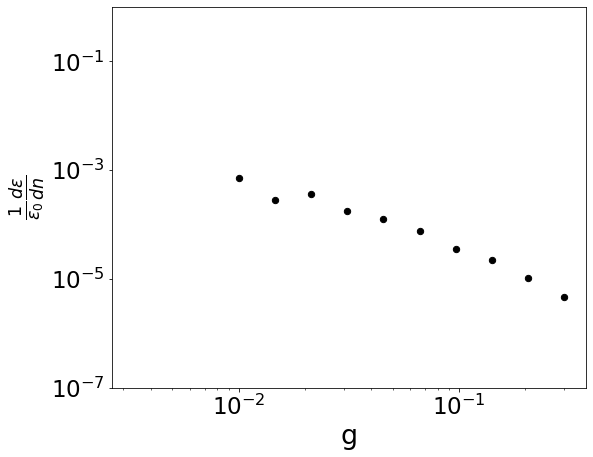

In [11]:
fig, ax = plt.subplots()
turns_list = np.arange(0, data['study_parameters']['turns'])

for index, gain in enumerate(gain_list):
    sum_rate = 0
    for version in versions:
           sum_rate = sum_rate + rate_dictionary['v{}'.format(version)]['gain{}'.format(gain)][0]
    average_rate = sum_rate/3.
    ax.scatter(gain, average_rate , s=40, c = 'k')
ax.set_ylim(10e-8, 10e-1)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('g')
ax.set_ylabel(r'$\frac{1}{\epsilon_0} \frac{d\epsilon}{dn}$', fontsize = 25)

### Plot rate vs noise vs theoretical rate + error bars
- add error bars, standard error $\sigma_x$

\begin{equation}
\sigma_x = \frac{\sigma}{\sqrt{n}}
\end{equation}
, where $\sigma$ is the standard deviation of the population and $n$ the number of observations of the sample

0.00015930792241564004
2.0406266624780936e-05
2.4322587870971522e-05
3.650823156223492e-05
1.4536177542476173e-05
1.3739334755310215e-05
4.176155733800486e-06
6.1497332316186954e-06
1.4239779959436652e-06
2.28873462854291e-07
theory rate [0.004375, 0.002054607597185567, 0.0009648942579228914, 0.0004531380737849379, 0.0002128047837651583, 9.993836010087451e-05, 4.693351175166261e-05, 2.204113138458607e-05, 1.035105736990532e-05, 4.861111111111114e-06]


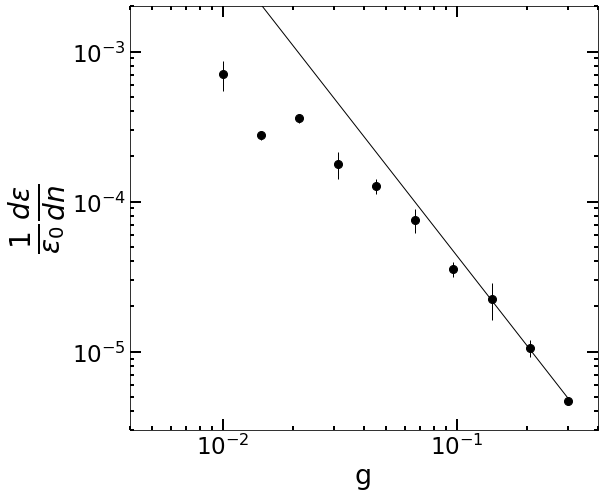

In [14]:
fig, ax = plt.subplots()
turns_list = np.arange(0, data['study_parameters']['turns'])

theory_rate = []
A = 3.5 # for this case, maybe you should obtain it from a fit. Lebdev P.171

for index, gain in enumerate(gain_list):
    current_version_rate = [] # the rate for this study, you need to store them in a list to calculate the average and the standard deviation
    for version in versions:
           current_version_rate.append(rate_dictionary['v{}'.format(version)]['gain{}'.format(gain)][0])
    # Calculate average and variance
    average_rate = np.mean(current_version_rate)
    standard_error = np.std(current_version_rate)/sqrt(len(versions))
    print(standard_error)
    
    #ax.scatter(Deltas_list_real[index], average_rate , s=40, c = 'r')
    ax.errorbar(gain, average_rate, yerr=standard_error, c='k', marker ='o', ms =8)
    
    
    theory_rate.append(A*((data['BB']['values_limits']['max']**2)*((data['Noise']['values_limits']['max']**2))/(2*gain**2)))

# Plot theoretical rate
ax.plot(gain_list, theory_rate, c = 'k') 
print('theory rate', theory_rate)
    
ax.set_xlim(4e-3, 0.4)    
ax.set_ylim(3e-6, 2e-3)

   
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('g')
ax.set_ylabel(r'$\frac{1}{\epsilon_0} \frac{d\epsilon}{dn}$', fontsize = 40)

# Set the ticks in both sides of the axes
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
# Display minor ticks on the axis
ax.minorticks_on() 

# Set the appearance of the ticks
ax.tick_params(which='both',direction='in', width=2)
ax.tick_params(which='major',direction='in', length=11)
ax.tick_params(which='minor',direction='in', length=4)


# Make axis equal. Note that the size of the figure affects this
ax.set_aspect(aspect='auto')

savefig = False
plt.tight_layout()
if savefig:
    plt.savefig('./figures/rate_vs_gain_Qx62.78_ksi0.010_gScan_delta0.050_betax115.75_particles15000_turns1000.png')